## Conversion Rate
- Optimizing conversion rate is likely the most common task for ds/da. 
- The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue. 
- pros: no dates/no table joins, no feature engineering, and problem is straightforward.

#### Data: User data
#### Task: predict conversion rate and provide recommendations to improve it

In [65]:
# data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
plt.style.use('ggplot')
%matplotlib inline

# machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

# ignore the warnings if need to
import warnings
warnings.filterwarnings('ignore')

In [66]:
# read file
data = pd.read_csv("conversion_data.csv")
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


## Data Quality Check
- First, inspect the data to look for the quality and do some cleaning work.

In [67]:
# overview 
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [68]:
# check missing data
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [69]:
# check unique values for each column
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:10])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted                2	 [0, 1]


In [70]:
# check data type
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [71]:
# Classfify the features into categorical and numerical features
catcols = data.select_dtypes(include='object').columns.values.tolist()
numcols = [x for x in data.columns if x not in catcols]
print('The categorical varaibles are: ', catcols)
print('The numerical varaibles are: ',numcols)

The categorical varaibles are:  ['country', 'source']
The numerical varaibles are:  ['age', 'new_user', 'total_pages_visited', 'converted']


### A few quick observations:
- No missing data in this datasets
- Age have outliers with the unrealistic values of 123 which need to be cleaned.


## Exploratory Data Analysis

In [77]:
data.groupby(['country']).size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [78]:
data.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

### Remove Outliers

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


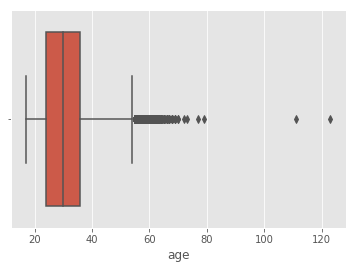

In [79]:
_ = sns.boxplot(data['age'])
print(sorted(data['age'].unique(), reverse=True))

In [80]:
print(data[data['age'] > 100])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


- Only two users with the unrealistic age values, thus I simply drop those two rows.

In [84]:
data = data[data['age'] < 100]

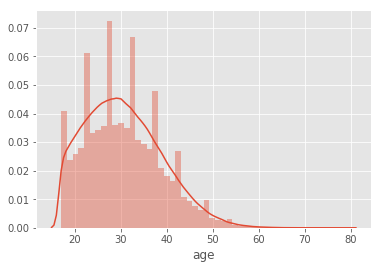

In [87]:
_ = sns.distplot(data['age'])

- After the data cleaning, we can see Age has a positively skewed distribution, which means our user base here is pretty young and the average age is around 30 years old.

In [101]:
grouped = data.groupby('country').count()
print(grouped)

            age  new_user  source  total_pages_visited  converted
country                                                          
China     76602     76602   76602                76602      76602
Germany   13055     13055   13055                13055      13055
UK        48449     48449   48449                48449      48449
US       178092    178092  178092               178092     178092


### Relationship between Conversion and Features

   country  converted
0    China   0.001332
1  Germany   0.062428
2       UK   0.052612
3       US   0.037801


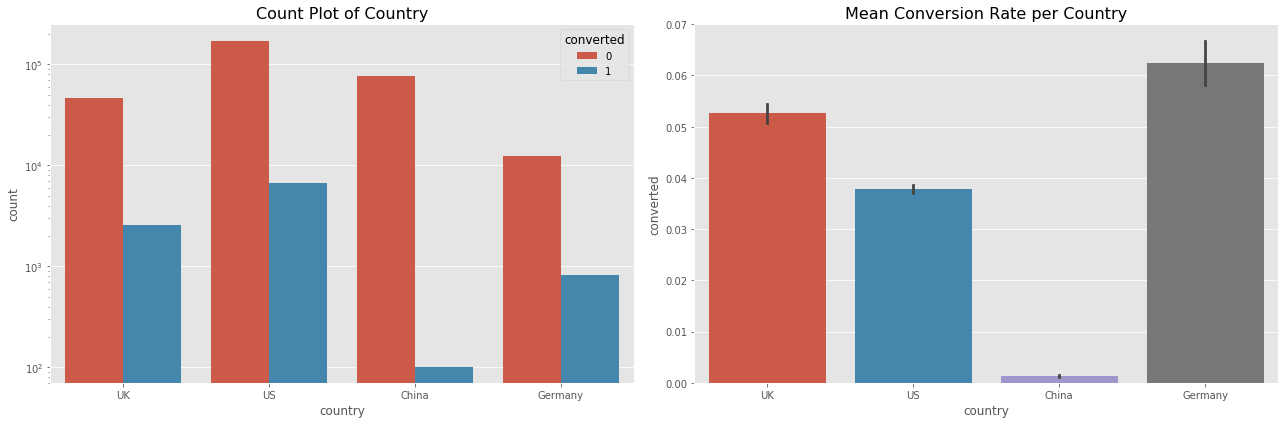

In [53]:
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()
print(grouped)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()

- Here it clearly looks like Chinese convert at a much lower rate than other countries! 

   source  converted
0     Ads   0.034472
1  Direct   0.028169
2     Seo   0.032888


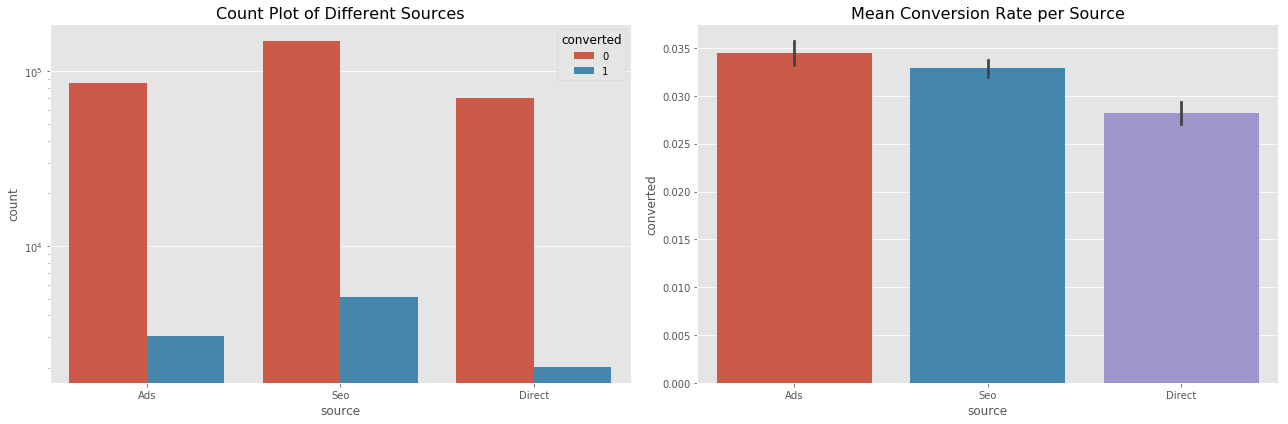

In [54]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()
print(grouped)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()


- Source is less relevant

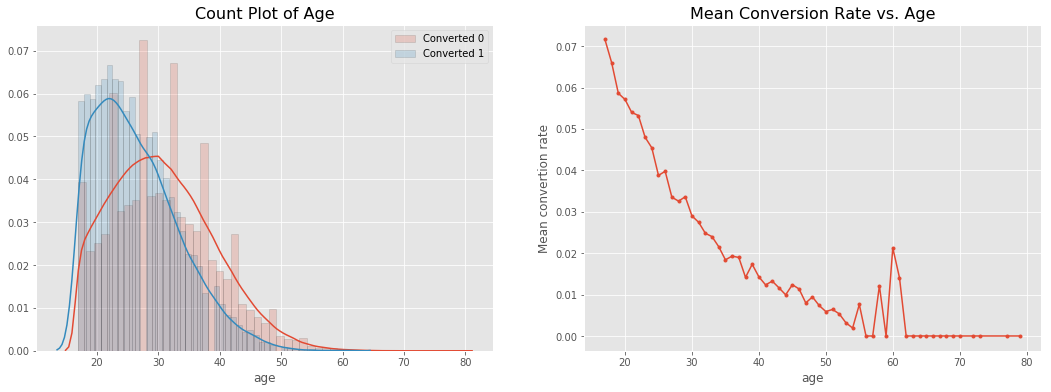

In [55]:
# Visualization of different ages
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)


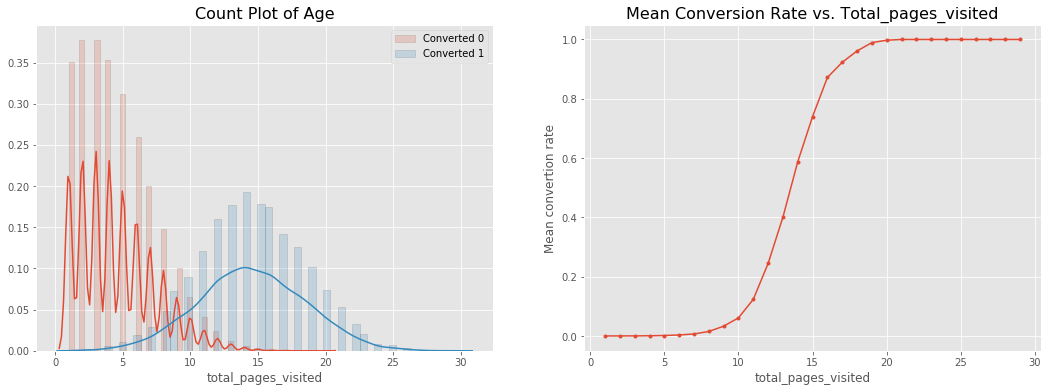

In [56]:
# Visualization of different pages visited
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)


Definitely spending more time on the site implies higher probability of conversion!

### Bussiness Insights

- The site is probably a US site, although it does have a large Chinese user base as well. However, the conversion rate in China is a much lower rate than other countries.
- Different sources make small impact on the change of conversation rate, while Ads contributes the highest conversion rate.
- The user base is pretty young; there seems a nagative relations between age and conversion rate.
- Spending more time on the site definitely implies higher probability of conversion.

## Machine Learning

### Building a model to predict conversion rate
- I am going to pick a random forest to predict conversion rate. 
- I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments. 

In [88]:
# create dummy variables for the categorical features
data_dummy = pd.get_dummies(data, drop_first=True)

In [89]:
# split the data into train and test with a standard 66% split to avoid overfitting

train, test = train_test_split(data_dummy, test_size = 0.34)
  
# build the model
# standard values for the 3 important parameters: 100 trees, trees as large as possible, 
# 3 random variables selected at each split

# feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
# target = 'converted'

rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
# get the OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.984100819397192 
 OOB Confusion Matrix 
         0     1
0  200907  1096
1    2222  4465


In [90]:
# get the test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9846802098448487 
 Test Set Confusion Matrix 
         0     1
0  103489   508
1    1139  2372


- The results shows a high accurancy and low OOB error in both train and and test sets. Thus we are confident we are not overfitting and the predict result is good. 
- In order to deeply understand the variables which related to conversion, I check variable importance then. 

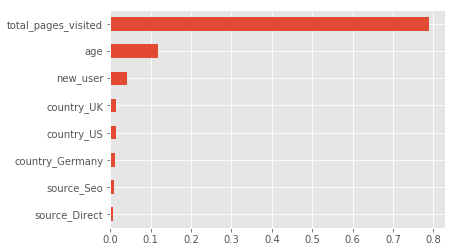

In [91]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

- Without any doubt, total pages visited is the most important feature. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Thus, these two factors are mutually causal. 
- Thus, for getting more actionable insights from data, I rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, I change the weights to deal with the imbalanced data issue. 

In [93]:
# build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, 
                            class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
# OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8917101921510374 
 OOB Confusion Matrix 
         0      1
0  183165  18838
1    3761   2926


In [94]:
# test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8913476206421848 
 Test Set Confusion Matrix 
        0     1
0  94223  9774
1   1907  1604


- Accuracy went down, but it's still acceptable. The model is still good enough to give us insights.
- Then I recheck the variable importance without total pages visited.

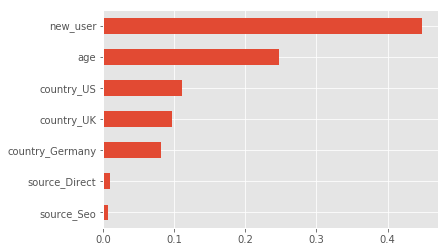

In [95]:
feat_importances = pd.Series(rf.feature_importances_, 
                             index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')


- Interesting! New user is the most important one, even more important than age. And that’s impressive given that continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don’t seem to matter at all.

## Conclusions and next steps

#### Age-wise

1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

2. Even through the site works very well for young people but gets worse for older people. Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

#### Country-wise

1. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

2. The site is working very well for Germany in terms of conversion. But the charts showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
